# Preliminary Project Code

This is a KMeans to find focal colours simply based on the WCS data given.

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
from skimage.color import lab2rgb
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from wcs_helper_functions import *

In [2]:
# To verify venv
import sys
print(sys.executable)

c:\Users\user\Downloads\wcs_data_notebook\.venv\Scripts\python.exe


## Load WCS

In [3]:
naming_data = readNamingData("./WCS_data_core/term.txt")
foci_data = readFociData('./WCS_data_core/foci-exp.txt')
cnum_dict, cname_dict = readChipData('./WCS_data_core/chip.txt')
speaker_data = readSpeakerData('./WCS_data_core/spkr-lsas.txt')
clab_data = readClabData('./WCS_data_core/cnum-vhcm-lab-new.txt')

## Analysis

In [4]:
def get_unique_terms_per_language(naming_data):
    """Count the unique colour terms for each language."""
    language_terms = {}

    for lang_id in naming_data:
        all_terms = set()

        for speaker_id in naming_data[lang_id]:
            for chip_id in naming_data[lang_id][speaker_id]:
                term = naming_data[lang_id][speaker_id][chip_id]
                all_terms.add(term)
        
        language_terms[lang_id] = len(all_terms)
    
    return language_terms

In [5]:
language_term_counts = get_unique_terms_per_language(naming_data)
term_distribution = Counter(language_term_counts.values())

In [6]:
for n_terms in sorted(term_distribution.keys()):
    langs = [l for l, c in language_term_counts.items() if c == n_terms]
    print(f"{n_terms} terms: {term_distribution[n_terms]} languages - Examples: {langs}")

4 terms: 1 languages - Examples: [105]
5 terms: 3 languages - Examples: [66, 74, 77]
6 terms: 3 languages - Examples: [23, 30, 104]
7 terms: 2 languages - Examples: [12, 100]
8 terms: 6 languages - Examples: [25, 31, 33, 36, 90, 99]
9 terms: 5 languages - Examples: [1, 5, 40, 65, 108]
10 terms: 5 languages - Examples: [21, 29, 50, 53, 94]
11 terms: 6 languages - Examples: [11, 49, 55, 93, 96, 101]
12 terms: 4 languages - Examples: [73, 79, 85, 89]
13 terms: 9 languages - Examples: [9, 22, 26, 35, 37, 41, 45, 82, 110]
14 terms: 5 languages - Examples: [16, 71, 87, 98, 106]
15 terms: 3 languages - Examples: [15, 75, 81]
16 terms: 1 languages - Examples: [39]
17 terms: 6 languages - Examples: [8, 18, 58, 69, 78, 107]
18 terms: 1 languages - Examples: [46]
19 terms: 6 languages - Examples: [10, 20, 24, 38, 83, 102]
20 terms: 2 languages - Examples: [61, 68]
21 terms: 2 languages - Examples: [7, 56]
22 terms: 4 languages - Examples: [60, 76, 86, 92]
23 terms: 4 languages - Examples: [14, 34

## Extract Focals

In [7]:
def extract_focal_colors_lab(foci_data, cnum_dict, clab_data):
    """Extract focal colours in LAB space for each language + term"""
    focal_colors_by_lang = {}
    
    for lang_id in foci_data:
        focal_colors_by_lang[lang_id] = {}

        for speaker_id in foci_data[lang_id]:
            for term in foci_data[lang_id][speaker_id]:
                if term not in focal_colors_by_lang[lang_id]:
                    focal_colors_by_lang[lang_id][term] = []

                grid_coords = foci_data[lang_id][speaker_id][term]

                for coord in grid_coords:
                    coord_key = coord.replace(':', '')

                    if coord_key in cnum_dict:
                        chip_num = cnum_dict[coord_key]

                        if chip_num in clab_data:
                            lab_values = clab_data[chip_num]
                            L = float(lab_values[0])
                            a = float(lab_values[1])
                            b = float(lab_values[2])
                            focal_colors_by_lang[lang_id][term].append([L, a, b])
                            
    return focal_colors_by_lang

In [8]:
focal_colors_lab = extract_focal_colors_lab(foci_data, cnum_dict, clab_data)

## Cluster Foci for Prototypes

In [9]:
def find_prototypes_by_n_terms(focal_colors_lab, language_term_counts, n_terms):
    """Find prototype colors for languages with n terms."""
    target_langs = [l for l, c in language_term_counts.items() if c == n_terms]
    all_focals = []

    for lang_id in target_langs:
        if lang_id in focal_colors_lab:
            for _, colors in focal_colors_lab[lang_id].items():
                if colors:
                    # Use mean of focal colors for each term
                    mean_color = np.mean(colors, axis=0)
                    all_focals.append(mean_color)

    if len(all_focals) >= n_terms:
        kmeans = KMeans(n_clusters=n_terms, n_init=10)
        kmeans.fit(all_focals)
        prototypes = kmeans.cluster_centers_

        # Sort by lightness
        prototypes = prototypes[np.argsort(prototypes[:, 0])]
        
        return prototypes
    
    return None


# Find prototypes for different numbers of terms
prototypes_by_n = {}
for n in range(4, 11):
    prototypes = find_prototypes_by_n_terms(
        focal_colors_lab, language_term_counts, n)
    
    if prototypes is not None:
        prototypes_by_n[n] = prototypes
        print(f"Prototypes for {n}-term languages:")

        for i, proto in enumerate(prototypes):
            L, a, b = proto
            color_name = "Dark" if L < 40 else "Light" if L > 70 else "Mid"

            if abs(a) > 20:
                color_name += "-Red" if a > 0 else "-Green"

            if abs(b) > 20:
                color_name += "-Yellow" if b > 0 else "-Blue"

            print(f"\tColor {i+1} ({color_name:16s}): L={L:.1f}, a={a:.1f}, b={b:.1f}")

Prototypes for 5-term languages:
	Color 1 (Dark            ): L=17.7, a=1.7, b=1.5
	Color 2 (Mid-Green       ): L=52.5, a=-33.3, b=1.5
	Color 3 (Mid-Red         ): L=54.7, a=41.8, b=18.1
	Color 4 (Mid-Yellow      ): L=68.9, a=18.0, b=63.5
	Color 5 (Light           ): L=91.2, a=0.7, b=-2.0
Prototypes for 6-term languages:
	Color 1 (Dark            ): L=17.6, a=-3.7, b=0.4
	Color 2 (Mid-Red-Yellow  ): L=46.0, a=55.9, b=20.6
	Color 3 (Mid-Green       ): L=57.2, a=-44.2, b=13.7
	Color 4 (Mid-Blue        ): L=57.8, a=-14.7, b=-27.3
	Color 5 (Light-Yellow    ): L=80.2, a=4.8, b=90.6
	Color 6 (Light           ): L=94.8, a=-0.1, b=-0.0
Prototypes for 7-term languages:
	Color 1 (Dark            ): L=16.0, a=-0.9, b=-0.5
	Color 2 (Mid-Red-Yellow  ): L=44.6, a=55.1, b=21.0
	Color 3 (Mid-Blue        ): L=46.8, a=12.6, b=-37.4
	Color 4 (Mid-Green       ): L=52.2, a=-36.6, b=-0.9
	Color 5 (Mid-Green-Yellow): L=54.4, a=-51.8, b=30.5
	Color 6 (Light-Yellow    ): L=81.0, a=-1.9, b=74.0
	Color 7 (Light 

Image saved to wcs_color_prototypes.png


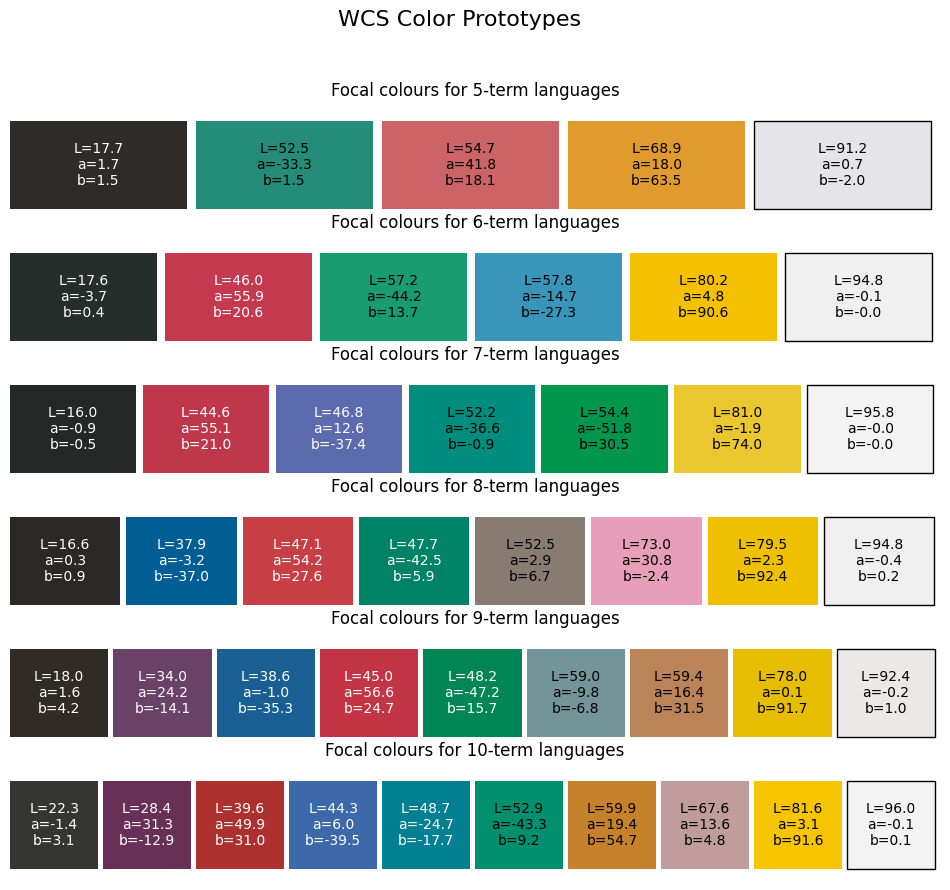

In [10]:
num_languages = len(prototypes_by_n)

# One row for each N-term group
fig, axes = plt.subplots(nrows=num_languages, ncols=1, 
                            figsize=(12, 10), squeeze=False)
axes = axes.flatten()  # 1D array

for i, (n_terms, prototypes) in enumerate(prototypes_by_n.items()):
    ax = axes[i]
    ax.set_title(f"Focal colours for {n_terms}-term languages", pad=10)
    
    num_colors = len(prototypes)
    
    for j, lab_color in enumerate(prototypes):
        L, a, b = lab_color
        
        lab_array = np.array([[lab_color]], dtype=np.float64)
        rgb_array = lab2rgb(lab_array)
        
        rgb_color = rgb_array[0][0]
        
        rgb_color_clipped = np.clip(rgb_color, 0, 1)

        x_pos = j / num_colors
        width = 1 / num_colors * 0.95  # Gap in between colours
        
        rect = patches.Rectangle(
            (x_pos, 0.1), width, 0.8,
            facecolor=rgb_color_clipped,
            edgecolor='black' if L > 90 else 'none'  # Border for light colors
        )
        ax.add_patch(rect)
        
        text_color = 'white' if L < 50 else 'black'
        
        ax.text(
            x_pos + (width / 2), 0.5,
            f"L={L:.1f}\na={a:.1f}\nb={b:.1f}",
            ha='center', va='center',
            color=text_color,
            fontsize=10
        )
    
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.axis('off')

plt.suptitle("WCS Color Prototypes", fontsize=16)

output_filename = "wcs_color_prototypes.png"
plt.savefig(output_filename)
print(f"Image saved to {output_filename}")

For the 5-term language, we can actually see the black/white-red-yellow/green progression, very cool.